https://mediacentre.manchesterairport.co.uk/manchester-airport-celebrates-busiest-month-on-record-and-summer-holiday-success/

## For now just looking at August. We can change the initial data later.

### First issue I noticed is that there are some features with non-numerical values such as ID. This needs to be in a numerical format for PCA analysis.

# https://towardsdatascience.com/using-principal-component-analysis-pca-for-machine-learning-b6e803f5bf1e/

In [65]:
pip install -r requirements.txt 

8015.95s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [36]:
import pandas as pd

csv_file = "features.csv"     # CSV of the features extracted file

# Read CSV
df = pd.read_csv(csv_file)
df.head(5)

,id,type,taxi_time,gate (block) hour,runway hour,rwy_day,distance,angle,angle error,shortest path,...,operation_mode,other_moving_ac,QDepDep,QDepArr,QArrDep,QArrArr,NDepDep,NDepArr,NArrDep,NArrArr
0,01-Aug-2021_EZY28TA,arrival,7.116667,23,23,31,1209.120799,369.163842,0,1029.622192,...,0,1,0,0,0,0,0,0,0,0
1,02-Aug-2021_EZY28TA,arrival,0.583333,22,22,2,408.809244,146.955823,0,64.253358,...,0,3,0,0,1,1,0,0,1,2
2,04-Aug-2021_EZY28TA,arrival,3.700000,22,22,4,1839.191193,425.834773,0,1424.002925,...,0,2,0,0,0,0,0,0,0,2
3,06-Aug-2021_EZY28TA,arrival,2.516667,23,23,5,773.289352,192.872935,0,435.692492,...,0,0,0,0,0,0,0,0,0,0
4,05-Aug-2021_EZY28TA,arrival,0.900000,22,22,5,548.248437,223.230689,0,167.657243,...,0,0,0,0,0,0,0,0,0,0


### Firstly Ill turn "type" into numerical data entries. For this Arrival = 0 and Departure = 1

In [37]:
df["type"] = df["type"].map({"arrival": 0, "departure": 1})
df.head(5)

,id,type,taxi_time,gate (block) hour,runway hour,rwy_day,distance,angle,angle error,shortest path,...,operation_mode,other_moving_ac,QDepDep,QDepArr,QArrDep,QArrArr,NDepDep,NDepArr,NArrDep,NArrArr
0,01-Aug-2021_EZY28TA,0,7.116667,23,23,31,1209.120799,369.163842,0,1029.622192,...,0,1,0,0,0,0,0,0,0,0
1,02-Aug-2021_EZY28TA,0,0.583333,22,22,2,408.809244,146.955823,0,64.253358,...,0,3,0,0,1,1,0,0,1,2
2,04-Aug-2021_EZY28TA,0,3.700000,22,22,4,1839.191193,425.834773,0,1424.002925,...,0,2,0,0,0,0,0,0,0,2
3,06-Aug-2021_EZY28TA,0,2.516667,23,23,5,773.289352,192.872935,0,435.692492,...,0,0,0,0,0,0,0,0,0,0
4,05-Aug-2021_EZY28TA,0,0.900000,22,22,5,548.248437,223.230689,0,167.657243,...,0,0,0,0,0,0,0,0,0,0


### Removing Features - ID and RWY as they arent useful information and they are non-numerical. They are identifiers and not physical data so having unnecessary data to compile into principle components would cause overfitting

In [38]:
df = df.drop(columns=["id"])
df = df.drop(columns=["rwy"])
df.head(5)

,type,taxi_time,gate (block) hour,runway hour,rwy_day,distance,angle,angle error,shortest path,distance_gate,...,operation_mode,other_moving_ac,QDepDep,QDepArr,QArrDep,QArrArr,NDepDep,NDepArr,NArrDep,NArrArr
0,0,7.116667,23,23,31,1209.120799,369.163842,0,1029.622192,83.432228,...,0,1,0,0,0,0,0,0,0,0
1,0,0.583333,22,22,2,408.809244,146.955823,0,64.253358,0.000000,...,0,3,0,0,1,1,0,0,1,2
2,0,3.700000,22,22,4,1839.191193,425.834773,0,1424.002925,88.909014,...,0,2,0,0,0,0,0,0,0,2
3,0,2.516667,23,23,5,773.289352,192.872935,0,435.692492,83.091828,...,0,0,0,0,0,0,0,0,0,0
4,0,0.900000,22,22,5,548.248437,223.230689,0,167.657243,0.000000,...,0,0,0,0,0,0,0,0,0,0


### PCA is sensitive to extreme values so Outliers need to be removed. This will be done using the IQR*1.5 method

In [39]:
Current_rows = len(df)
print(Current_rows)

8700


### It is extremely important that the IQR outlier removal ONLY affects clear outliers. Not features like QArrArr which represents the number of aircraft on standby as this value is 0 most of the time but during peak hours it can go to 100+. Using the IQR method would remove these important congestion values. I feel like 1.5* IQR still removes very important data

In [40]:
#Defining continous features
continuous_features = ["taxi_time", "distance", "angle", "angle error","shortest path", "distance_gate", "distance_long", "distance_else"]
#Creating a loop that goes through each feature one by one
for features in df.columns:
    if features in continuous_features: 
        Q1 = df[features].quantile(0.25) # Calculates the 25th percentile value
        Q3 = df[features].quantile(0.75) # Calculates the 75th percentile value
        IQR = Q3 - Q1                         
        lower_bound_outlier = Q1 - (1.5 * IQR)                
        upper_bound_outlier = Q3 + (1.5 * IQR)                
        #Eliminating values outside of the 1.5*IQR range
        df = df[(df[features] >= lower_bound_outlier) & (df[features] <= upper_bound_outlier)]
    else:
        continue

#Checking amount of rows in data after outlier removal
Current_rows2 = len(df)
print(Current_rows2)

6755


In [41]:
df.head(5) 

,type,taxi_time,gate (block) hour,runway hour,rwy_day,distance,angle,angle error,shortest path,distance_gate,...,operation_mode,other_moving_ac,QDepDep,QDepArr,QArrDep,QArrArr,NDepDep,NDepArr,NArrDep,NArrArr
0,0,7.116667,23,23,31,1209.120799,369.163842,0,1029.622192,83.432228,...,0,1,0,0,0,0,0,0,0,0
2,0,3.700000,22,22,4,1839.191193,425.834773,0,1424.002925,88.909014,...,0,2,0,0,0,0,0,0,0,2
3,0,2.516667,23,23,5,773.289352,192.872935,0,435.692492,83.091828,...,0,0,0,0,0,0,0,0,0,0
5,0,5.250000,23,23,6,1958.738673,530.808786,0,1440.492365,109.502424,...,0,3,0,0,0,0,0,0,1,1
6,0,3.250000,23,23,7,1516.676331,420.250419,0,1093.875551,83.432228,...,0,4,0,0,0,0,0,0,1,2


### Checking for the number of each features that have only 1 unique value because if a feature has the same float value then its uneccesary for PCA analysis and can be dropped.

In [42]:
df.nunique()

type                    2
taxi_time            1161
gate (block) hour      24
runway hour            24
rwy_day                31
distance             1934
angle                1948
angle error             1
shortest path         861
distance_gate          95
distance_long         132
distance_else        1717
rwy_num                 2
operation_mode          2
other_moving_ac        22
QDepDep                12
QDepArr                12
QArrDep                11
QArrArr                 9
NDepDep                13
NDepArr                10
NArrDep                11
NArrArr                 9
dtype: int64

### We can now drop angle_error as it only has one value which means it has no variance therefore it contributes nothing to PCA and removing it would remove the extra noise and dimensionality

In [43]:
df = df.drop(columns=["angle error"])

In [44]:
#Printing out new pre-processed csv file
df.to_csv("cleaned_featurestest.csv", index=False)

# Now it is important to compute the amount of Principle Components we would require to capture as much data as possible. 

### Now I will calculate the mean and subtract it from the data frame to get centered values

In [45]:
means = df.mean()

#Turning the data frame into zero-mean data frame

zero_mean = df - means

zero_mean.head(5)

,type,taxi_time,gate (block) hour,runway hour,rwy_day,distance,angle,shortest path,distance_gate,distance_long,...,operation_mode,other_moving_ac,QDepDep,QDepArr,QArrDep,QArrArr,NDepDep,NDepArr,NArrDep,NArrArr
0,-0.49208,-1.478443,11.226647,11.138712,15.378534,-796.886074,-113.001686,-684.534639,-7.135018,-700.526542,...,-0.002665,-4.627979,-1.052998,-0.658919,-0.330866,-0.331754,-1.217321,-0.940489,-0.792746,-0.971577
2,-0.49208,-4.895110,10.226647,10.138712,-11.621466,-166.815679,-56.330755,-290.153907,-1.658232,-700.526542,...,-0.002665,-3.627979,-1.052998,-0.658919,-0.330866,-0.331754,-1.217321,-0.940489,-0.792746,1.028423
3,-0.49208,-6.078443,11.226647,11.138712,-10.621466,-1232.717521,-289.292593,-1278.464340,-7.475418,-700.526542,...,-0.002665,-5.627979,-1.052998,-0.658919,-0.330866,-0.331754,-1.217321,-0.940489,-0.792746,-0.971577
5,-0.49208,-3.345110,11.226647,11.138712,-9.621466,-47.268200,48.643257,-273.664467,18.935178,-700.526542,...,-0.002665,-2.627979,-1.052998,-0.658919,-0.330866,-0.331754,-1.217321,-0.940489,0.207254,0.028423
6,-0.49208,-5.345110,11.226647,11.138712,-8.621466,-489.330542,-61.915109,-620.281281,-7.135018,-700.526542,...,-0.002665,-1.627979,-1.052998,-0.658919,-0.330866,-0.331754,-1.217321,-0.940489,0.207254,1.028423


### Now sorting the using the zero-mean data to compute the covariance matrix and the corresponding eigenvectors and eigenvalues

In [46]:
#computing the covariance matric using pandas library
covariance_matrix = zero_mean.cov()

#computing the eigenvectors and eigen values using numpy
import numpy as np

eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

print(eigenvalues)

[-1.75357576e-09  2.64504776e-03  4.08177688e-02  1.61598977e-01
  2.17295483e-01  2.38011092e-01  3.21368027e-01  3.42867806e-01
  5.99805197e-01  6.82290812e-01  1.05618214e+00  1.84643621e+00
  3.13728833e+00  7.38501704e+00  1.43395101e+01  6.22256118e+01
  8.25790089e+01  3.58448226e+02  7.52509071e+03  1.25897806e+04
  3.61371234e+05  1.45634250e+06]


### Sorting eigenvalues by descending order and then computing the variance using the following equation:

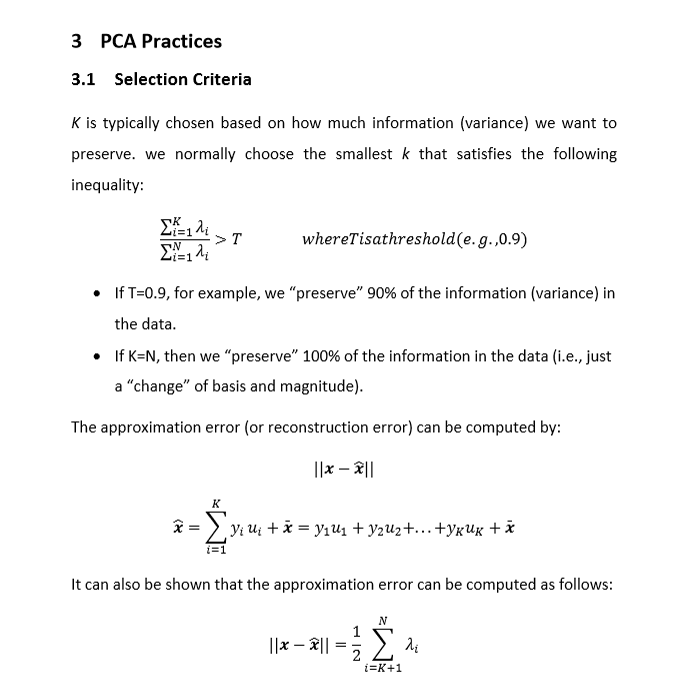

In [47]:
#Sorting indices in descending order (Largest to Smallest) eigenvalue
idx = np.argsort(eigenvalues)[::-1]

#This creates a new list of eigenvalues and eigenvectors that are in descending order
descending_eigenvalues = eigenvalues[idx]         
descending_eigenvectors = eigenvectors[:, idx]  

#Computing the sum of all eigenvalues
total_lambda = descending_eigenvalues.sum()

# variance captured by each principal component
explained_ratio = descending_eigenvalues / total_lambda          # From equation in Week 3, page 10

# cumulative variance for each component k
cumulative_variance = np.cumsum(explained_ratio)  

### Now calculating the information loss which would just be 1 - cumulative variance

In [48]:
information_loss = 1.0 - cumulative_variance

### Now calculating the approximation error as shown in the equation at the bottom of the figure above

In [49]:
approximation_error = []
for k in range(1, len(descending_eigenvalues) + 1):
    error_k = 0.5 * descending_eigenvalues[k:].sum()
    approximation_error.append(error_k)

### Now plotting a table 

In [50]:
pc_index = np.arange(1, len(descending_eigenvalues) + 1)

pca_table = pd.DataFrame({
    "Principle Component": pc_index,
    "Cumulative Variance": cumulative_variance,
    "Information Loss": information_loss,
    "Approximation_error": approximation_error
})

print(pca_table)

    Principle Component  Cumulative Variance  Information Loss  \
0                     1             0.792196      2.078044e-01   
1                     2             0.988768      1.123201e-02   
2                     3             0.995616      4.383638e-03   
3                     4             0.999710      2.902714e-04   
4                     5             0.999905      9.528903e-05   
5                     6             0.999950      5.036915e-05   
6                     7             0.999983      1.652076e-05   
7                     8             0.999991      8.720601e-06   
8                     9             0.999995      4.703429e-06   
9                    10             0.999997      2.996862e-06   
10                   11             0.999998      1.992470e-06   
11                   12             0.999999      1.417947e-06   
12                   13             0.999999      1.046806e-06   
13                   14             0.999999      7.205349e-07   
14        

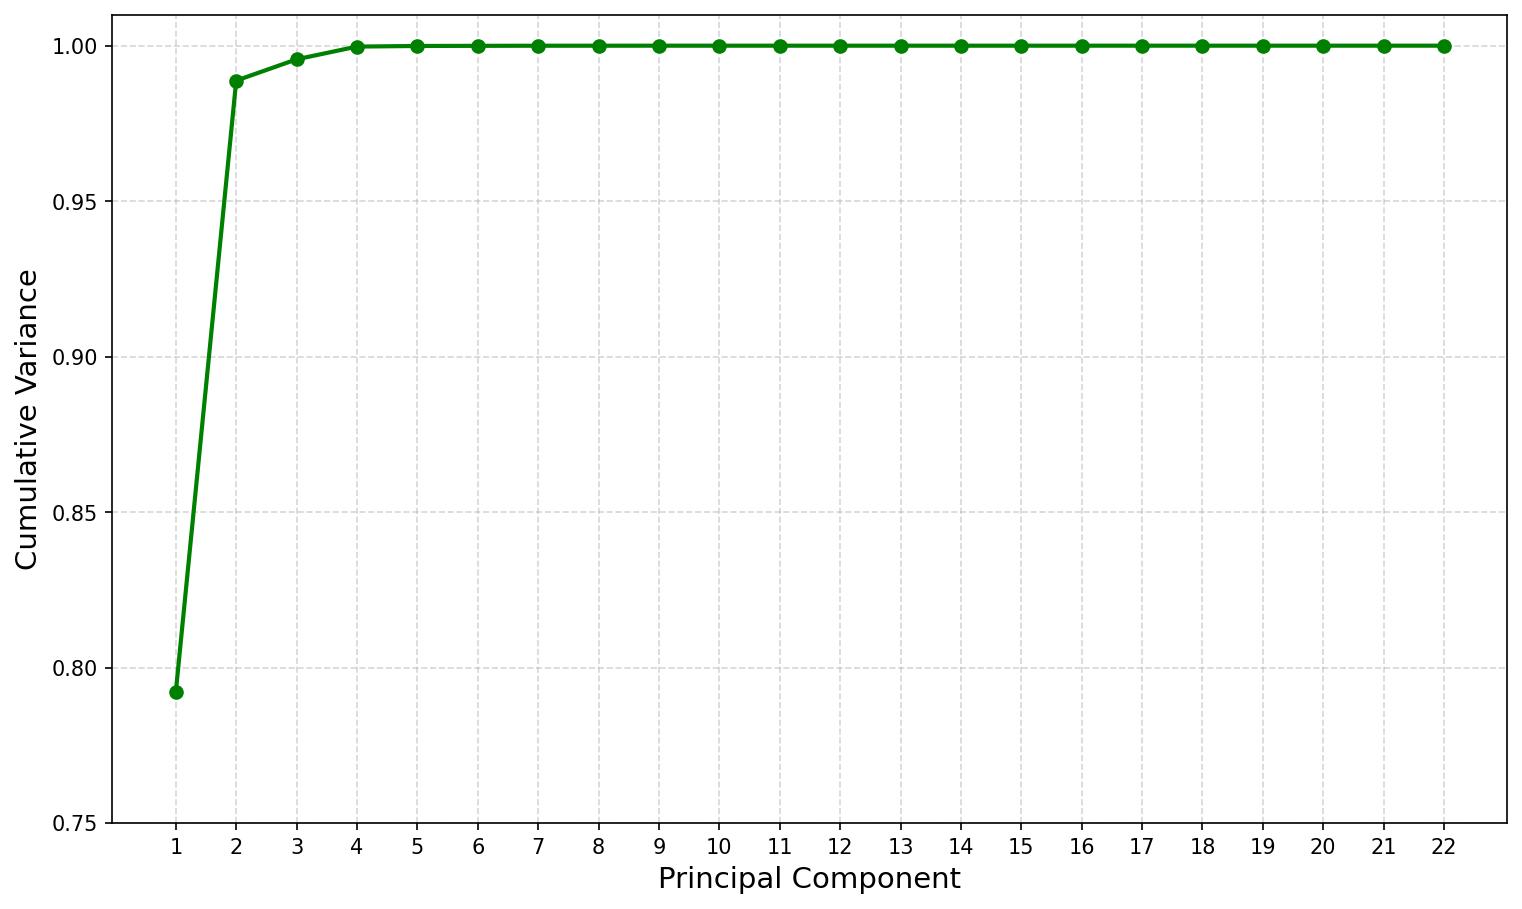

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7), dpi=150)   # Improving resolution

plt.plot(
    range(1, len(cumulative_variance)+1),
    cumulative_variance,
    marker='o',
    markersize=6,
    linewidth=2,
    color='green'
)

plt.title("", fontsize=16)
plt.xlabel("Principal Component", fontsize=14)
plt.ylabel("Cumulative Variance", fontsize=14)

# Focusing between 0.75 and 1.01
plt.ylim(0.75, 1.01) 

plt.xticks(range(1, len(cumulative_variance)+1))
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

### MLP-BPNN: Imports

Imports for the Multi-Layer Perceptron and Back Propagation Neural Network

What does each one do? 
- numpy for arrays
- pandas for data manipulation and preparation
- matplotlib for tabelling and graph plotting
- sklearn for ML streamlining, and stat modelling

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


### Load PCA-Reduced Data:

- function train = reading the post PCA training file
- function val = reading the post PCA transformed validation file
- function test = reading the post PCA transformed test file

In [53]:
train = pd.read_csv("PCA_train_reduced_gX.csv")
val   = pd.read_csv("PCA_validation_reduced_gX.csv")
test  = pd.read_csv("PCA_test_reduced_gX.csv")

print("Train shape:", train.shape)
print("Validation shape:", val.shape)
print("Test shape:", test.shape)
print("\nColumns:", train.columns)

X_train = train[["PC1", "PC2"]].values
y_train = train["taxi_time"].values.reshape(-1, 1)

X_val = val[["PC1", "PC2"]].values
y_val = val["taxi_time"].values.reshape(-1, 1)

X_test = test[["PC1", "PC2"]].values
y_test = test["taxi_time"].values.reshape(-1, 1)


Train shape: (4728, 3)
Validation shape: (1351, 3)
Test shape: (676, 3)

Columns: Index(['PC1', 'PC2', 'taxi_time'], dtype='object')


### Standardise Features:

standardising mean 0, standard deviation 1 / matrix scaling

In [54]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

print("Scaled shapes:", X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape)


Scaled shapes: (4728, 2) (1351, 2) (676, 2)


### Activations:

sigmoid and derivative of sigmoid

In [55]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def d_sigmoid(x):
    s = sigmoid(x)
    return s * (1 - s)


### Backpropagations (BP):

2 -> H -> 1 network with: 
- bias included by extending inputs and hidden activations
- sigmoid in hidden layer
- linear output (for regression)

In [56]:
class MLP_BPNN:

    def __init__(self, n_in, n_hidden, n_out=1, lr=0.01, random_state=42):
        np.random.seed(random_state)
        self.n_in = n_in
        self.n_hidden = n_hidden
        self.n_out = n_out
        self.lr = lr

        # +1 for bias in each layer
        # W1: (n_in + 1, n_hidden)
        self.W1 = np.random.randn(n_in + 1, n_hidden) * np.sqrt(2 / (n_in + 1))

        # W2: (n_hidden + 1, n_out)
        self.W2 = np.random.randn(n_hidden + 1, n_out) * np.sqrt(2 / (n_hidden + 1))

    def _forward(self, x):
        """
        x: (n_in,) row vector
        returns: y_pred scalar, plus cached intermediates for backprop
        """
        # Add bias to input: x_b: (n_in + 1,)
        x_b = np.hstack([1.0, x])  

        # Hidden layer
        z1 = x_b @ self.W1             # (n_hidden,)
        h = sigmoid(z1)                # (n_hidden,)

        # Add bias to hidden: h_b: (n_hidden + 1,)
        h_b = np.hstack([1.0, h])

        # Output layer (linear)
        z2 = h_b @ self.W2             # (n_out,)
        y_pred = z2                    # linear activation

        cache = (x_b, z1, h, h_b, z2)
        return y_pred, cache

    def _backward(self, y_pred, y_true, cache):
        """
        y_pred: (1,) or scalar
        y_true: (1,) or scalar
        cache from forward pass
        returns: gradients dW1, dW2 with correct shapes
        """
        x_b, z1, h, h_b, z2 = cache

        # Ensure shapes are 1D
        y_pred = np.array(y_pred).reshape(-1)   # (1,)
        y_true = np.array(y_true).reshape(-1)   # (1,)

        # dL/dy_pred = (y_pred - y_true)
        delta_out = (y_pred - y_true)          # (1,)

        # Gradients for W2: outer(h_b, delta_out)
        dW2 = np.outer(h_b, delta_out)         # (n_hidden + 1, n_out)

        # Backprop to hidden (no bias neuron)
        # W2 without bias row: shape (n_hidden, n_out)
        W2_no_bias = self.W2[1:, :]            
        delta_hidden = (W2_no_bias @ delta_out) * d_sigmoid(z1)  # (n_hidden,)

        # Gradients for W1: outer(x_b, delta_hidden)
        dW1 = np.outer(x_b, delta_hidden)      # (n_in + 1, n_hidden)

        return dW1, dW2

    def fit(self, X, y, epochs=2000, verbose=True):
        """
        X: (N, n_in)
        y: (N, 1)
        """
        N = X.shape[0]
        losses = []

        for epoch in range(epochs):
            dW1_sum = np.zeros_like(self.W1)
            dW2_sum = np.zeros_like(self.W2)
            loss = 0.0

            for i in range(N):
                x_i = X[i]
                y_i = y[i]

                y_pred, cache = self._forward(x_i)
                loss += 0.5 * np.sum((y_pred - y_i)**2)

                dW1, dW2 = self._backward(y_pred, y_i, cache)
                dW1_sum += dW1
                dW2_sum += dW2

            # Batch gradient descent
            self.W1 -= self.lr * dW1_sum / N
            self.W2 -= self.lr * dW2_sum / N

            losses.append(loss / N)

            if verbose and epoch % 100 == 0:
                print(f"Epoch {epoch}, MSE = {loss / N:.4f}")

        return losses

    def predict(self, X):
        """
        X: (N, n_in)
        returns: (N,) predictions
        """
        preds = []
        for i in range(X.shape[0]):
            y_pred, _ = self._forward(X[i])
            preds.append(y_pred.item())
        return np.array(preds)


### Create and Train the Network:

one full pass through the entire training dataset.

basically, passes through 4728 samples, processes, forward prop + back prop, update weights on batch at time, 2000 times 

- n_in = 2  (two principal components selected through PCA)
- n_hidden = 12 (was chosen to provide sufficient model capacity without overfitting; this value can be adjusted as part of hyperparameter tuning)
- lr = 0.01 (Learning Rate controls the step size of gradient descent updates)
- epochs = 2000 (model performs 2000 full passes over the training dataset, for the network to converge)
- The model trains using backpropagation via the MLP_BPNN class.

In [57]:
n_in = X_train_scaled.shape[1]   # should be 2 (PC1, PC2)
n_hidden = 12                    # you can tune this
lr = 0.01
epochs = 2000

nn = MLP_BPNN(n_in=n_in, n_hidden=n_hidden, n_out=1, lr=lr, random_state=42)

losses = nn.fit(X_train_scaled, y_train, epochs=epochs, verbose=True)


Epoch 0, MSE = 54.0465
Epoch 100, MSE = 8.0338
Epoch 200, MSE = 6.0115
Epoch 300, MSE = 5.5228
Epoch 400, MSE = 5.4218
Epoch 500, MSE = 5.4003
Epoch 600, MSE = 5.3936
Epoch 700, MSE = 5.3896
Epoch 800, MSE = 5.3862
Epoch 900, MSE = 5.3831
Epoch 1000, MSE = 5.3802
Epoch 1100, MSE = 5.3775
Epoch 1200, MSE = 5.3749
Epoch 1300, MSE = 5.3725
Epoch 1400, MSE = 5.3702
Epoch 1500, MSE = 5.3680
Epoch 1600, MSE = 5.3660
Epoch 1700, MSE = 5.3640
Epoch 1800, MSE = 5.3622
Epoch 1900, MSE = 5.3604


### Evaluate on Train / Validation / Test:

RMSE - Measures the average magnitude of prediction error. Lower values indicate better performance.

MAE - Provides the average absolute difference between predicted and actual taxi times.

R² - Indicates how much variance in the target variable is explained by the model. / Values closer to 1 represent better predictive accuracy.

The model's performance is evaluated separately on the training, validation, and test sets to assess:
- fit quality (training performance)
- hyperparameter selection (validation performance)
- generalisation ability (test performance)


In [32]:
y_train_pred = nn.predict(X_train_scaled)
y_val_pred   = nn.predict(X_val_scaled)
y_test_pred  = nn.predict(X_test_scaled)

def print_metrics(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"\n{name} set:")
    print(f"  RMSE = {rmse:.4f}")
    print(f"  MAE  = {mae:.4f}")
    print(f"  R²   = {r2:.4f}")
    return rmse, mae, r2

rmse_tr, mae_tr, r2_tr = print_metrics("Train", y_train, y_train_pred)
rmse_va, mae_va, r2_va = print_metrics("Validation", y_val, y_val_pred)
rmse_te, mae_te, r2_te = print_metrics("Test", y_test, y_test_pred)



Train set:
  RMSE = 3.2738
  MAE  = 2.5664
  R²   = 0.4881

Validation set:
  RMSE = 3.3249
  MAE  = 2.5735
  R²   = 0.4759

Test set:
  RMSE = 3.3179
  MAE  = 2.6101
  R²   = 0.4610


### Plot Training Loss (Optional but nice for report)

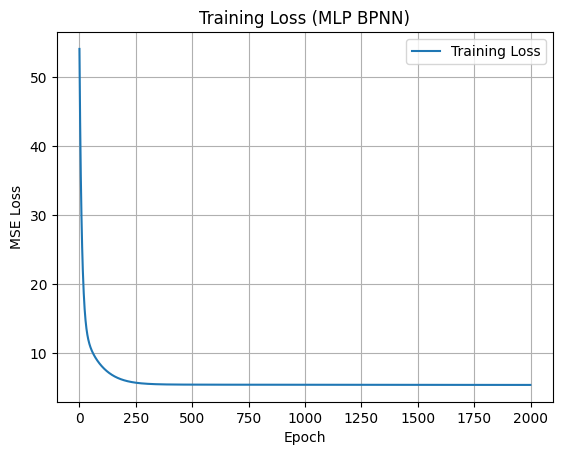

In [64]:
plt.figure()
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss (MLP BPNN)")
plt.legend(["Training Loss"], loc="upper right")
plt.grid(True)
plt.savefig("MLP_BPNN_Training_Loss.png")
plt.show()



### Predicted vs Actual (Test)

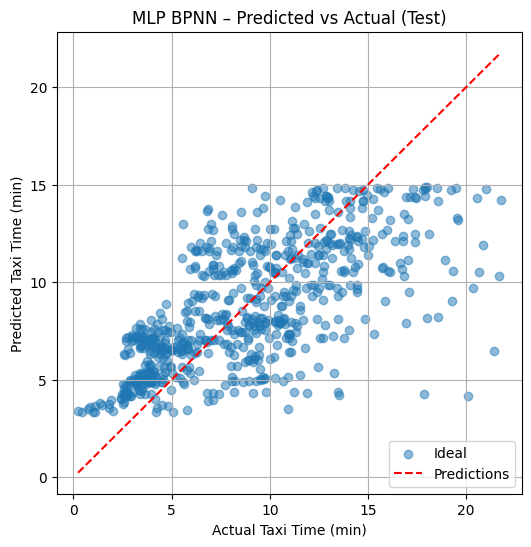

In [63]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
min_tt = min(y_test.min(), y_test_pred.min())
max_tt = max(y_test.max(), y_test_pred.max())
plt.plot([min_tt, max_tt], [min_tt, max_tt], 'r--')
plt.xlabel("Actual Taxi Time (min)")
plt.ylabel("Predicted Taxi Time (min)")
plt.title("MLP BPNN – Predicted vs Actual (Test)")
plt.legend(["Ideal", "Predictions"], loc="lower right")
plt.grid(True)
plt.savefig("MLP_BPNN_Predicted_vs_Actual_Test.png")
plt.show()


### Residual Plot (Test)

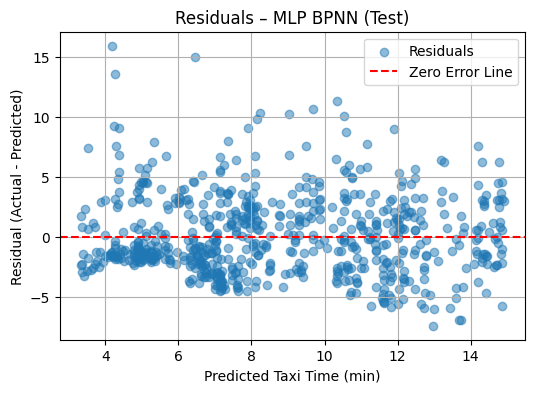

In [62]:
residuals = y_test.flatten() - y_test_pred

plt.figure(figsize=(6,4))

# Scatter (label included)
plt.scatter(y_test_pred, residuals, alpha=0.5, label="Residuals")

# Zero error line (label included)
plt.axhline(0, color="red", linestyle="--", label="Zero Error Line")

plt.xlabel("Predicted Taxi Time (min)")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals – MLP BPNN (Test)")
plt.grid(True)
plt.legend()

# SAVE BEFORE SHOW
plt.savefig("MLP_BPNN_Residuals_Test.png", dpi=300, bbox_inches="tight")
plt.show()

